In [1]:
import os
import gc
import math
import torch
import random
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.

# define dataset
class HemoglobinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)  # return the number of sample

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Initialising LSTM weights and biases
        self.W_ii = nn.ParameterList([nn.Parameter(torch.Tensor(input_dim if i == 0 else hidden_dim, hidden_dim)) for i in range(num_layers)])
        self.W_hi = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)) for _ in range(num_layers)])
        self.b_i = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim)) for _ in range(num_layers)])
        
        self.W_if = nn.ParameterList([nn.Parameter(torch.Tensor(input_dim if i == 0 else hidden_dim, hidden_dim)) for i in range(num_layers)])
        self.W_hf = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)) for _ in range(num_layers)])
        self.b_f = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim)) for _ in range(num_layers)])
        
        self.W_ig = nn.ParameterList([nn.Parameter(torch.Tensor(input_dim if i == 0 else hidden_dim, hidden_dim)) for i in range(num_layers)])
        self.W_hg = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)) for _ in range(num_layers)])
        self.b_g = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim)) for _ in range(num_layers)])
        
        self.W_io = nn.ParameterList([nn.Parameter(torch.Tensor(input_dim if i == 0 else hidden_dim, hidden_dim)) for i in range(num_layers)])
        self.W_ho = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)) for _ in range(num_layers)])
        self.b_o = nn.ParameterList([nn.Parameter(torch.Tensor(hidden_dim)) for _ in range(num_layers)])
 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self._init_weights()

    def _init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Initialise hidden and cell states
        h_t = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):

                # input gate
                i_t = torch.sigmoid(x_t @ self.W_ii[layer] + h_t @ self.W_hi[layer] + self.b_i[layer])
                # Forget Gate
                f_t = torch.sigmoid(x_t @ self.W_if[layer] + h_t @ self.W_hf[layer] + self.b_f[layer])
                # input modulation gate
                g_t = torch.tanh(x_t @ self.W_ig[layer] + h_t @ self.W_hg[layer] + self.b_g[layer])
                # output gate
                o_t = torch.sigmoid(x_t @ self.W_io[layer] + h_t @ self.W_ho[layer] + self.b_o[layer])
                # Updating the cell state
                c_t_new = f_t * c_t + i_t * g_t
                # Updating the hidden state
                h_t_new = o_t * torch.tanh(c_t_new)

                c_t = c_t_new
                h_t = h_t_new

                # Use the output of the current layer as the input of the next layer
                x_t = self.dropout(h_t)

        # The hidden state of the last layer passes through the fully connected layer
        out = self.fc(h_t)
        return out

In [3]:
# 1. Read Data
def load_data(a):
    data = []
    labels = []
    for i in a:
        df = pd.read_csv(i)
        if df.shape[0] == 249:
            df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
            features = df[['Red (a.u)', 'Infra Red (a.u)', 'Gender']].values
            label = df['Hemoglobin (g/dL)'].values[-1] 
            data.append(features)
            labels.append(label)
    return np.array(data), np.array(labels)

In [4]:
# Get all file paths
address = "../Code/Raw dataset"
datapath = [os.path.join(address, f) for f in os.listdir(address) if f.endswith('.csv')]
# Load Data
X, y = load_data(datapath)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# 3. Data Standardization
scaler = StandardScaler()

# Standardization
X_train_shape = X_train.shape
X_val_shape = X_val.shape
X_test_shape = X_test.shape

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train_shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val_shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test_shape)


In [7]:
# create datasets
train_dataset = HemoglobinDataset(X_train, y_train)
val_dataset = HemoglobinDataset(X_val, y_val)
test_dataset = HemoglobinDataset(X_test, y_test)

# create loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # set init values 
    epoch_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Gradient clearing
        optimizer.zero_grad()
        # forward pass
        outputs = model(inputs).squeeze(-1)
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        # record loss
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

def validate_one_epoch(model, valid_loader, criterion, device):
    # initialise
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(inputs).squeeze(-1)
            # calculate the batch loss
            loss = criterion(outputs, labels)
            # record loss
            valid_loss += loss.item()
    return valid_loss / len(valid_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_loader)  
    return test_loss

def get_predictions(model, test_loader, device):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze(-1)
            all_outputs.append(outputs.numpy())
            all_labels.append(labels.numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_outputs, all_labels

In [9]:
def fit(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    # initialise
    train_loss_min = np.Inf
    valid_loss_min = np.Inf
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs + 1):
        # clear useless data
        gc.collect()
        
        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}\n")
        train_losses.append(train_loss)

        if train_loss < train_loss_min:
            train_loss_min = train_loss

        gc.collect()

        if valid_loader is not None:
            gc.collect()
            
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss = validate_one_epoch(model, valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}\n")
            valid_losses.append(valid_loss)
            gc.collect()
            # show if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                print(f"Validation loss decreased ({valid_loss_min:.4f} --> {valid_loss:.4f}).")
                valid_loss_min = valid_loss
    
    print(f"Minimum Training Loss: {train_loss_min:.4f}")
    print(f"Minimum Validation Loss: {valid_loss_min:.4f}")

    return {
        "train_loss": train_losses,
        "valid_loss": valid_losses,
    }

In [12]:
device = torch.device("cpu")
input_dim = 3
output_dim = 1

hidden_dim = 8
num_layers = 1
dropout = 0.1
learning_rate = 0.2
epoch = 50

model = LSTM(input_dim, hidden_dim, num_layers, output_dim, dropout)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

set_seed(42)

# record start time
print(f"INITIALIZING TRAINING ")
start_time = datetime.now()
print(f"Start Time: {start_time}")

# train model
logs = fit(
    model=model,
    epochs=epoch,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=val_loader
)

INITIALIZING TRAINING 
Start Time: 2024-08-30 03:38:12.012673
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 157.52201334635416

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 120.87296295166016

EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 96.6099141438802

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 45.08788299560547

Validation loss decreased (inf --> 45.0879).
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 25.864303588867188

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 3.119838237762451

Validation loss decreased (45.0879 --> 3.1198).
EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 3.6922877629597983

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 7.395904541015625

EPOCH 5 - TRAINING...

	[TRAIN] EPOCH 5 - LOSS: 19.14268620808919

EPOCH 5 - VALIDATING...
	[VALID] LOSS: 15.5712308883667

EPOCH 6 - TRAINING...

	[TRAIN] EPOCH 6 - LOSS: 25.500478108723957

EPOCH 6 - VALIDATING...
	[VALID] LOSS: 21.959951400756836

EPOCH 7 - TRAINING...

	[TRAIN] EPOCH 7 - LOSS: 48.70373789469401

EPOCH 7 - VALIDATING...


In [13]:
test_loss = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')

predictions, true_labels = get_predictions(model, test_loader, device)
print(f'Predictions: {", ".join([f"{pred:.4f}" for pred in predictions])}')
print(f'True Labels: {", ".join([f"{label:.1f}" for label in true_labels])}')

# Calculate R²
r2 = r2_score(true_labels, predictions)
print("R² score:", r2)

Test Loss: 1.6464
Predictions: 12.5617, 12.3926, 12.5045, 11.9850, 12.5636, 12.5633, 11.9850, 15.1199, 11.9849, 11.9849, 15.0984
True Labels: 11.0, 13.7, 12.4, 11.6, 14.4, 13.8, 13.2, 14.3, 11.6, 12.9, 17.5
R² score: 0.4394515640318365


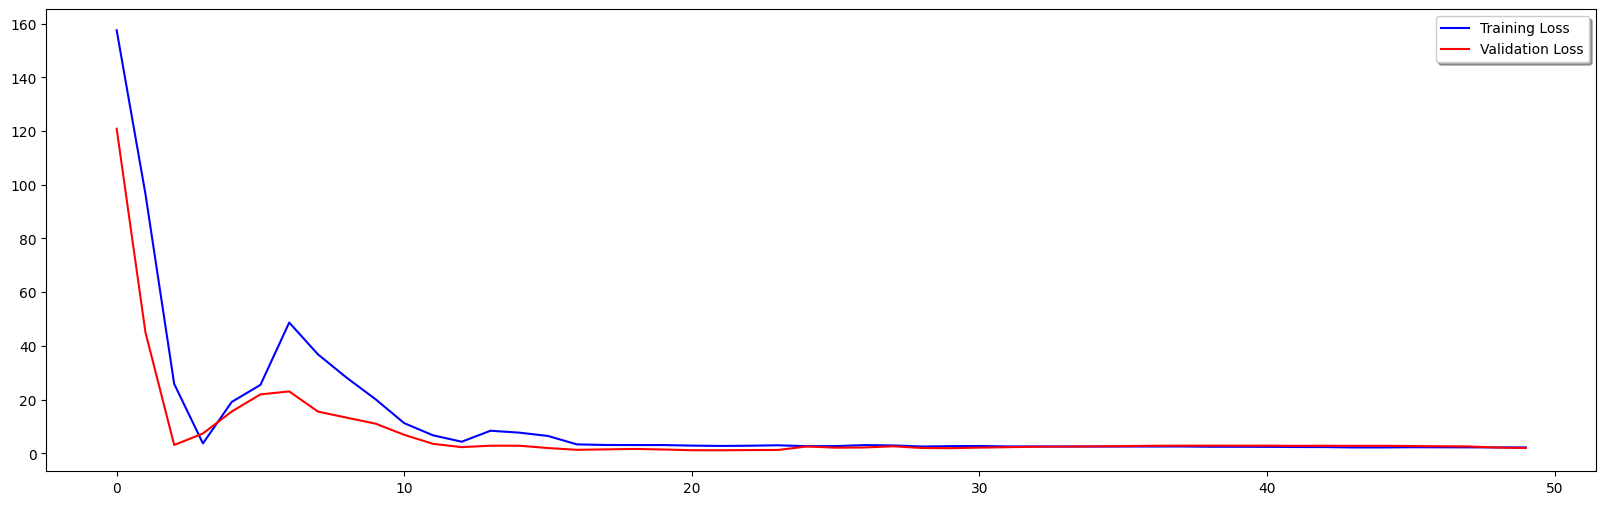

In [14]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(logs['train_loss'], color='b', label="Training Loss")
ax.plot(logs['valid_loss'], color='r', label="Validation Loss")
legend = ax.legend(loc='best', shadow=True)

In [15]:
torch.save(model, 'LSTM_model.pth')